## Лабораторная работа 5 - Создание классификатора
Разделы:
1. Загрузка данных
2. Предварительная обработка данных
3. Построение простой нейронной сети
5. Обучение
7. Построение усложненого варианта НС с делением данных на обучающую и тестовую выборку с визуализацие процесса обучения
6. Работа с "контрольными точками" в нейронной сети

### 0. Дополнительные библиотеки  
Одратите внимание, что для данной лабораторной работы необходимо установить 2 библиотеки
- tensorflow
- keras

In [2]:
!pip install tensorflow keras
# Если вам не повезло и tensorflow последней версии не устанавливается или не хочет работать, то надо поставить версию 1.5
# !pip install tensorflow==1.5

In [1]:
# подключение библиотек
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

%matplotlib inline

### 1. Загрузка данных

**Обратите внимание**  
При загрузки данных мы сразу же выбираем поле для индексации, это нужно для дальнейшего разделения данныех и удаления выбросов в обоих

In [2]:
import pandas as pd

data = pd.read_csv('../data/Iris.csv', index_col='Id')
print(f'Всего данных: {data.shape[0]}')
data.head()

Всего данных: 150


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


### 2. Предварительная обработка данных  

Готовим наши данные для подачи на вход нейронной сети

In [3]:
# Пишем наши собственные препроцессоры
# Обратите внивание тут добавлено несколько новых препроцессоров (в сравнение с 4 работой)
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from keras.utils import to_categorical

class FillNa(TransformerMixin, BaseEstimator):
    """
    Удаление пропусков в данных
    """
    
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем пропуски в данных
        """
        return X.interpolate(method='cubic').fillna(method='pad').dropna()
        
    
    
class DropOutlet(TransformerMixin, BaseEstimator):
    """
    Удаление выбросов, основываясь на правиле 3-х сигм (только для нормального распределения)
    """
        
    def fit(self, X: pd.DataFrame, y=None):
        """
        Получаем стандартное отклонение для каждого столбца и сохраняем их        
        """
        self.std = X.std()
        self.columns = self.std.index.values
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем все здачения, котоые находятся дальше 3-х стандартных отконений (сигма) от мат. ожидания случайной величины
        """
        X_cols = X[self.columns]
        return X[ (X_cols - X_cols.mean()).abs() <= 3*self.std ].dropna()

class PandasToNumpy(BaseEstimator):
    """
    Просто преобразует данные из DataFrame от pandas к матрице от numpy (ndarray)
    """
    
    def fit(self, X : pd.DataFrame = None, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        return X.values
    
class SparseToArray(TransformerMixin, BaseEstimator):
    """
    Класс преобразует sparse matrix в ndarray
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.toarray()

class ModifyLabelEncoder(preprocessing.LabelEncoder):
    """
    Стандартный костыль для препроцессора LabelEncoder
    """
    
    def fit(self, X, y=None):
        return super().fit(X)
    
    def transform(self, X, y=None):
        print(1)
        return super().transform(X)
    
    def fit_transform(self, X, y=None):
        return super().fit_transform(X)
    
    
class ExpandDims(TransformerMixin, BaseEstimator):
    """
    Увеличение на 1 рамерности массима в нужной оси
    """
    
    def __init__(self, axis):
        self.axis = axis
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.expand_dims(X, axis=self.axis)
        

j:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


У нас будет 2 pipeline'а:
1. Для входных данных
2. Для выходных

У входных и выходных данных будут общие следующие обработчики:
1. DropOutlet - наш класс для удаления выбросов
2. Конвертация из DataFrame в ndarray

*Препроцессор DropOutlet идет отдельно от всех других препроцессоров*


**Препроцессор для входных данных**:
1. Конвертация из DataFrame в ndarray
1. Нормализация с помощью препроцессора MinMaxScaler

**Препроцессор для выходных данных**:
1. Конвертация из DataFrame в ndarray
1. Преобразование из категорий в виде строк в числовой номер (1.2.3.4): ModifyLabelEncoder
1. Добавляем еще одну размерность для данных (нужно для следующего препроцессора): ExpandDims
1. Кодируем наши категории как вектор с одной 1 : OneHotEncoder  
*Вот наглядно, что делает OneHotEncoder*
![OneHotEncoder](https://3.bp.blogspot.com/-HDEv1_z3gc4/WhqyArqWc7I/AAAAAAAADjI/u9K8OrCY7TcLrNFDOuSQPeClCAv2jRv2wCLcBGAs/s1600/Screen%2BShot%2B2560-11-26%2Bat%2B7.21.59%2BPM.png)

У pipeline обектов есть 3 метода:
- fit - тренирует обект. Тут происходит запоминание особенностей данных (если они нужны)
- transform - непосредственное преобразование данных
- fit_transform - в начале тренирует, а потом преобразует

In [4]:
# Создадим наш pipeline
# drop_outlet, to_matrix, norm - это просто названия препроцессоров данное пользователем
# выбираем данные для обучающей выборки (то что будет подано на вход алгоритмам машинного обучения)
X_data = data[data.columns[:-1]].copy()
# Кодируем все классы в виде единичных векторов
X_data = pd.get_dummies(X_data)

# выбираем данные для обучающей выборки (то что будет на выходу алгоритмов машинного обучения)
Y_data = data[data.columns[-1]].copy()

# Создаем препроцессор для заполнения пропусков
fill_na_pipe = pipeline.Pipeline([
    ('fill', FillNa()),
])

# Убираем вылеты из данных
pipe_outlet = pipeline.Pipeline([
    ('fill_na', fill_na_pipe),
    ('drop_outlet', DropOutlet()),
])

outletless_data_X = pipe_outlet.fit_transform(X_data)

# Соглачуем два массива X и Y
# Записи которые были удалены из массива X должны быть удалены и из массива Y
# Для удаления записей мы берем индексы из массива X и оставляем записи в массиве Y с индексами, которые есть в X
outletless_data_Y = Y_data[ fill_na_pipe.fit_transform(Y_data).index.isin(outletless_data_X.index) ]

# Нормализуем данные X
pipe_x = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('norm', preprocessing.MinMaxScaler())
])

# Нормализуем данные Y
pipe_y = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
    ('expand_dims', ExpandDims(axis=1)),
    ('one_hot_encoder', preprocessing.OneHotEncoder(sparse=False))
])

# вызываем препроцессоры
number_data_ready_X = pipe_x.fit_transform(outletless_data_X)
number_data_ready_Y = pipe_y.fit_transform(outletless_data_Y)

print(number_data_ready_X.shape, number_data_ready_Y.shape)

(149, 4) (149, 3)


In [5]:
number_data_ready_X[:10,:], number_data_ready_Y[::10]

(array([[0.22222222, 0.68181818, 0.06779661, 0.04166667],
        [0.16666667, 0.45454545, 0.06779661, 0.04166667],
        [0.11111111, 0.54545455, 0.05084746, 0.04166667],
        [0.08333333, 0.5       , 0.08474576, 0.04166667],
        [0.19444444, 0.72727273, 0.06779661, 0.04166667],
        [0.30555556, 0.86363636, 0.11864407, 0.125     ],
        [0.08333333, 0.63636364, 0.06779661, 0.08333333],
        [0.19444444, 0.63636364, 0.08474576, 0.04166667],
        [0.02777778, 0.40909091, 0.06779661, 0.04166667],
        [0.16666667, 0.5       , 0.08474576, 0.        ]]),
 array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]))

Как можно видеть выше мы получили на выходе многомерный массив. именно его и мы будем в дальнейшем подавать на вход для алгоритмов машинного обучения

Для знакомства с массивами из библиотеки NumPy воспользуйтесь ссылкой http://cs231n.github.io/python-numpy-tutorial/

### 3. Построение простой нейронной сети


Для удобства работы с нейронной сеть, переопределим переменные
- number_data_ready_X теперь X_train
- number_data_ready_Y теперь Y_train

В перепенной X_train хранятся данные для тренировки сети (входные)  
В перепенной Y_train хранятся данные для тренировки сети (выходные или правильные ответы)

In [6]:
X_train = number_data_ready_X
Y_train = number_data_ready_Y
X_train.shape, Y_train.shape

((149, 4), (149, 3))

#### Подключаем библиотеку keras


```Python
from keras.layers import Dense
```
Строка отвечает за подключение сущности Dense которая реализует простой полносвязные слой сети (FFN)

```Python
from keras.models import Sequential
```
Строка отвечает за подключение сущности Sequential которая реализует саму нейронную сеть

```Python
from keras import activations
```
Это импорт (activations) содержи в себе список функций активании для сети

```Python
from keras.optimizers import Adam, RMSprop
```
Тут мы подключаем алгоритмы тренировки Адам и алгоритм обратного распостранения ошибки(RMSprop)

```Python
from keras.losses import categorical_crossentropy
```
Подключаем фукцию подсчета ошибки сети (кросэтропися для данных представленных в виде категорий)

```Python
from keras.metrics import categorical_accuracy
```
Подключаем фукцию подсчета метрики сети (точность попадания в категорию)


In [7]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import activations
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy

#### Создаем сеть
```Python
model = Sequential()
```
Создаем сущность сети

```Python
model.add(Dense(10, activation=activations.relu, input_dim=X_train.shape[1]))
```
Добавляем слой сети из 10 нейронов с функцией активации Relu и количеством входом равным количеству столбцов во входном массиве

```Python
model.add(Dense(Y_train.shape[1], activation=activations.softmax)) # output = 3
```
Добавляем последний слой(выходной) количество нейронов равно количеству столбцов в выходном массиве и функцией активации Softmax 

```Python
model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])
```
Компилируем (собираем) сеть с параметрами:
- алгоритм обучения: *Adam*
- Функция обибки: *categorical_crossentropy*
- дополнительные метрики:
    - categorical_accuracy


In [8]:
model = Sequential()
model.add(Dense(10, activation=activations.relu, input_dim=X_train.shape[1])) # input_dim = 4
model.add(Dense(Y_train.shape[1], activation=activations.softmax)) # output = 3

model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])

### 4. Обучение

Запускаем оучение сети с параметрами:
- 1 параметр: матрица с входным массивом
- 2 параметр: матрица с требуемыми ответами (выходная матрица)
- verbose=2 : устанавливаем уровень вывода отладочной информации на 2 уровень
- epochs=100 : задаем количество эпох для обучения (100 для начала более чем достаточно)
- batch_size=3 : размер группы для обучения (пакетный метод), гду говоря как часто пересчитывать веса сети (влияет на скорость и что более важно на качество обучения (параметр подбирается опытным путем) )

In [9]:
model.fit(X_train, Y_train, verbose=2, epochs=100, batch_size=3)

Epoch 1/100
 - 0s - loss: 1.0705 - categorical_accuracy: 0.6309
Epoch 2/100
 - 0s - loss: 1.0227 - categorical_accuracy: 0.6644
Epoch 3/100
 - 0s - loss: 0.9842 - categorical_accuracy: 0.6577
Epoch 4/100
 - 0s - loss: 0.9483 - categorical_accuracy: 0.6577
Epoch 5/100
 - 0s - loss: 0.9142 - categorical_accuracy: 0.6577
Epoch 6/100
 - 0s - loss: 0.8799 - categorical_accuracy: 0.6644
Epoch 7/100
 - 0s - loss: 0.8447 - categorical_accuracy: 0.6644
Epoch 8/100
 - 0s - loss: 0.8106 - categorical_accuracy: 0.6711
Epoch 9/100
 - 0s - loss: 0.7777 - categorical_accuracy: 0.6644
Epoch 10/100
 - 0s - loss: 0.7437 - categorical_accuracy: 0.6711
Epoch 11/100
 - 0s - loss: 0.7126 - categorical_accuracy: 0.6779
Epoch 12/100
 - 0s - loss: 0.6842 - categorical_accuracy: 0.6779
Epoch 13/100
 - 0s - loss: 0.6567 - categorical_accuracy: 0.7181
Epoch 14/100
 - 0s - loss: 0.6323 - categorical_accuracy: 0.7181
Epoch 15/100
 - 0s - loss: 0.6092 - categorical_accuracy: 0.7114
Epoch 16/100
 - 0s - loss: 0.5885 

Посчитаем точность сети (1 цифра показывает ошибку сети, 2 метрику (точность) )

In [10]:
model.evaluate(X_train, Y_train)

149/149 [==============================] - 0s 148us/step


[0.121475345736382, 0.9664429534201654]

### 5. Построение усложненого варианта НС с делением данных на обучающую и тестовую выборку с визуализацие процесса обучения

In [11]:
# Подключим новые библиотеки
# библиотека дополнительных возможностей (действий) при обучении сети
from keras import callbacks

#### Разделение на обучающую и тестовую выборки
Для полноценной оценки работы сети ее надо оценивать не только на тренировочной выборе (это наш 1 вариант сети), но и на тестовой (это та выборка которая никогда не подавалась на нейронную сеть)

In [12]:
# Делим
# Делить будем в отношении 80/20
# 80 - это обучение
# 20 - тест
# первым делом перемешаем выборку (надо для того что бы обе выборки были репрезентативными)
XY_data = np.hstack( (number_data_ready_X, number_data_ready_Y) ).transpose((0,1))
np.random.shuffle(XY_data)
# Делим выборки
point_split = round(XY_data.shape[0] * 0.8)
train_data = XY_data[:point_split]
test_data = XY_data[point_split:]
print(f'Всего данных: {XY_data.shape[0]}')
print(f'Тренировочных данных: {train_data.shape[0]}')
print(f'Тестовых данных: {test_data.shape[0]}')
# Делим все на входные и выходные данные
# Тренировочные
X_train = train_data[:, :number_data_ready_X.shape[1] ]
Y_train = train_data[:, number_data_ready_X.shape[1]: ]
print(f'Размер данные для тренировки (входных): {X_train.shape}')
print(f'Размер данные для тренировки (выходных): {Y_train.shape}')

# Тестовые
X_test = test_data[:, :number_data_ready_X.shape[1] ]
Y_test = test_data[:, number_data_ready_X.shape[1]: ]
print(f'Размер данные для теста (входных): {X_test.shape}')
print(f'Размер данные для теста (выходных): {Y_test.shape}')

Всего данных: 149
Тренировочных данных: 119
Тестовых данных: 30
Размер данные для тренировки (входных): (119, 4)
Размер данные для тренировки (выходных): (119, 3)
Размер данные для теста (входных): (30, 4)
Размер данные для теста (выходных): (30, 3)


#### Именим способ создания сети

В работе библиотеки *keras* есть одна особенность  
**Запуская метод *fit* 2 и более раз вы будете обучать всегда одну и туже сеть**

Поэтому мы обернем создание сети в метод для того что бы при каждом вызове метода fit создавалась новая сеть

In [13]:
def make_nn(input_len, output_len):
    model = Sequential()
    model.add(Dense(10, activation=activations.relu, input_dim=input_len))
    model.add(Dense(output_len, activation=activations.softmax))
    model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])
    return model

В обучение модели добавим проверку на тестовых данных, так же добавим наш первый callback - *History*: он просто сохраняет историю измерения ошибки и метрик по эпохам

In [14]:
model = make_nn(X_train.shape[1], Y_train.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=100,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 119 samples, validate on 30 samples
Epoch 1/100
119/119 [==============================] - 0s 1ms/step - loss: 1.0954 - categorical_accuracy: 0.3193 - val_loss: 1.0874 - val_categorical_accuracy: 0.3667
Epoch 2/100
119/119 [==============================] - 0s 210us/step - loss: 1.0752 - categorical_accuracy: 0.3361 - val_loss: 1.0708 - val_categorical_accuracy: 0.3667
Epoch 3/100
119/119 [==============================] - 0s 202us/step - loss: 1.0545 - categorical_accuracy: 0.3782 - val_loss: 1.0524 - val_categorical_accuracy: 0.3333
Epoch 4/100
119/119 [==============================] - 0s 202us/step - loss: 1.0339 - categorical_accuracy: 0.3697 - val_loss: 1.0347 - val_categorical_accuracy: 0.2333
Epoch 5/100
119/119 [==============================] - 0s 193us/step - loss: 1.0147 - categorical_accuracy: 0.3025 - val_loss: 1.0175 - val_categorical_accuracy: 0.2667
Epoch 6/100
119/119 [==============================] - 0s 193us/step - loss: 0.9935 - cat

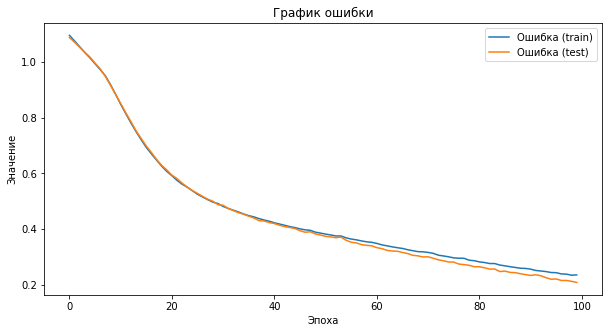

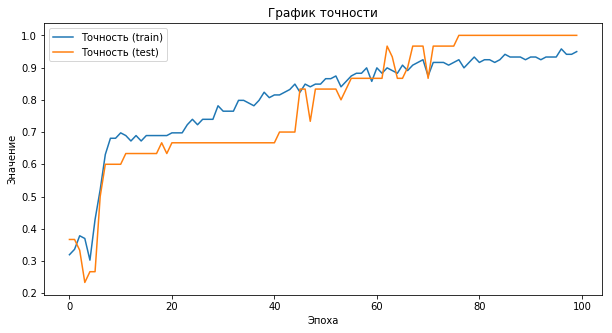

In [15]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

На самом деле в *keras* все готово для разделения данных на тренировочные и тестовые

In [16]:
model = make_nn(number_data_ready_X.shape[1], number_data_ready_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_ready_X,
    y=number_data_ready_Y,
    batch_size=3,
    epochs=100,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 119 samples, validate on 30 samples
Epoch 1/100
119/119 [==============================] - 0s 2ms/step - loss: 1.1310 - categorical_accuracy: 0.3361 - val_loss: 1.0686 - val_categorical_accuracy: 0.1667
Epoch 2/100
119/119 [==============================] - 0s 202us/step - loss: 1.0925 - categorical_accuracy: 0.4034 - val_loss: 1.0532 - val_categorical_accuracy: 0.7333
Epoch 3/100
119/119 [==============================] - 0s 202us/step - loss: 1.0506 - categorical_accuracy: 0.6303 - val_loss: 1.0484 - val_categorical_accuracy: 0.1000
Epoch 4/100
119/119 [==============================] - 0s 202us/step - loss: 1.0062 - categorical_accuracy: 0.6639 - val_loss: 1.0761 - val_categorical_accuracy: 0.0000e+00
Epoch 5/100
119/119 [==============================] - 0s 202us/step - loss: 0.9640 - categorical_accuracy: 0.7059 - val_loss: 1.0906 - val_categorical_accuracy: 0.0000e+00
Epoch 6/100
119/119 [==============================] - 0s 201us/step - loss: 0.92

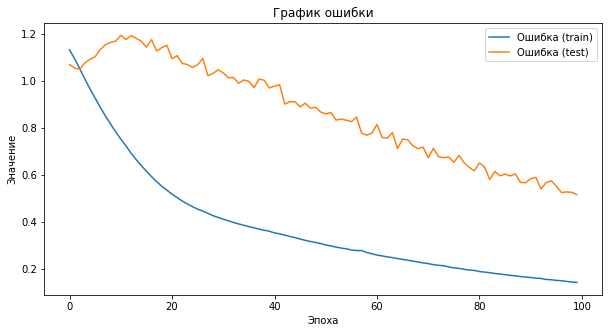

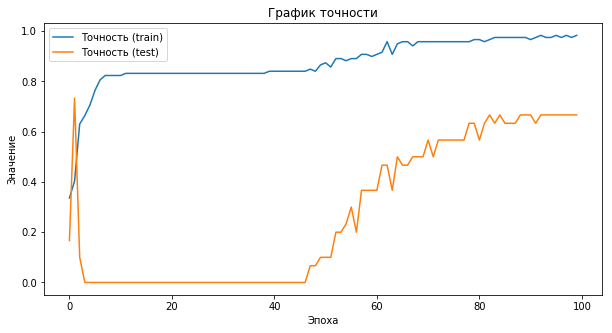

In [17]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

### Улучшение сети - Ранняя остановка
Как можно видеть на графиках выше - в какой, то момент сеть перестает улучшать свой результат и тут в лучшем случае ее надо останавливать, проблма в том, что вы не знаете заранее когда надо останавливаться (сколько нужно циклов обучения (эпох) ) 

In [23]:
model = make_nn(number_data_ready_X.shape[1], number_data_ready_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_ready_X,
    y=number_data_ready_Y,
    batch_size=3,
#     Так как у нас теперь есть рання остановка мы можем увеличеть количество эпох (было 100 стало 300)
    epochs=300,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping(
#             На основе какого значения будет приниматься решеня об остановке
            monitor='val_categorical_accuracy',
#             Указываем направления лучшего значения (min, max, auto) лучшим является если тестовая точноть будет максимальной
            mode='max',
#             Количество эпок в резельтате которых если значение не изменилось, то произвести остановку
            patience=50,
#             "Чуствительность" метода - изменения ниже данного значения дубут считатья 0 (изменения в отслеживаемом значении нету)
            min_delta=0.01,
        )
    ]
    
)

Начинаем обучение сети
Train on 119 samples, validate on 30 samples
Epoch 1/300
119/119 [==============================] - 0s 2ms/step - loss: 1.0050 - categorical_accuracy: 0.8319 - val_loss: 1.5528 - val_categorical_accuracy: 0.0000e+00
Epoch 2/300
119/119 [==============================] - 0s 210us/step - loss: 0.9601 - categorical_accuracy: 0.8319 - val_loss: 1.5523 - val_categorical_accuracy: 0.0000e+00
Epoch 3/300
119/119 [==============================] - 0s 210us/step - loss: 0.9136 - categorical_accuracy: 0.8319 - val_loss: 1.5140 - val_categorical_accuracy: 0.0000e+00
Epoch 4/300
119/119 [==============================] - 0s 210us/step - loss: 0.8681 - categorical_accuracy: 0.8319 - val_loss: 1.4363 - val_categorical_accuracy: 0.0000e+00
Epoch 5/300
119/119 [==============================] - 0s 210us/step - loss: 0.8194 - categorical_accuracy: 0.8319 - val_loss: 1.4117 - val_categorical_accuracy: 0.0000e+00
Epoch 6/300
119/119 [==============================] - 0s 218us/step 

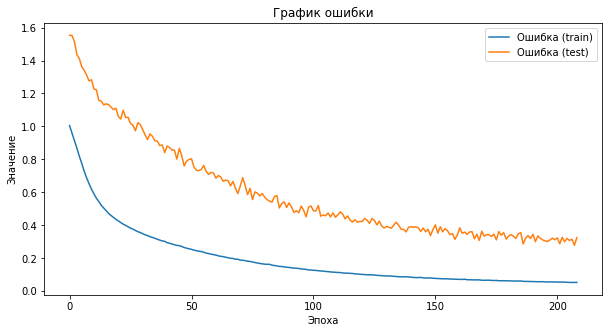

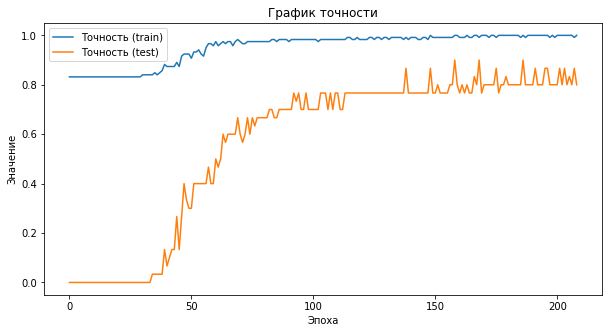

In [24]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

### 6. Контрольные точки
В обучении НС самый последний результат обучения не всегда самый лучший результат, это вызвано несколькими причинами, например переобучением сети или скатыванию к среднему значению.  
Для того что бы поймать тот самый лучший результат обучения, были придуманы "контрольные точки" *ModelCheckpoint*

Для использования контрольных точек необходимо подготовить директорию, где будут хранится контрольные точки

In [25]:
from pathlib import Path
from os import remove

In [26]:
# создадим функцию создания о очисти каталога контрольных точек
# указываем шаблон имени фала контрольной точки
file_name = 'nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{categorical_accuracy:.2f}_val_acc-{val_categorical_accuracy:.2f}.hdf5'
def make_save_points(name='save_points', file_name=file_name):
#     выбираем катагол (подробнее https://docs.python.org/3.6/library/pathlib.html ) 
    checkpoints_dir = Path('./').joinpath('save_points')
    print(f'Текущий каталог с контрольными точками {checkpoints_dir.absolute()}')
    # Создаем каталог если его нету
    checkpoints_dir.mkdir(exist_ok=True)
    # Удаляем все из каталога
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            print(f'Удаляем файл {item}')
            remove(item)
    return str(checkpoints_dir.joinpath(file_name))

    

In [27]:
print('Начинаем обучение сети')
history = make_nn(X_train.shape[1], Y_train.shape[1]).fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=300,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        callbacks.History(),
        # Добавляем сценарий ранней остановки
        # Если в течении 30 эпох точность не вырастить более чем на 1%, то произойдет остановка
        callbacks.EarlyStopping(
            monitor='val_categorical_accuracy',
            mode='max',
            patience=50,
            min_delta=0.01
        ),
#         Callback сохранений состояний сети
        callbacks.ModelCheckpoint(
#             Указываем путь для сохранения и формат имен файлов
            make_save_points(file_name=file_name),
#             Указываем какое значение отслеживать
            monitor='val_categorical_accuracy',
#             Указываем, что сохранять надо только лучшие результаты
            save_best_only=True,
#             Говорим как часто проверять, что текущий результат лучше предидущего (в эпохах)
            period=5,
#             Указываем сторону лучших значений
            mode='max'
        )
    ]
)

Начинаем обучение сети
Текущий каталог с контрольными точками C:\Users\Kross\Desktop\Tests\AI_1\лабы_задания\save_points
Train on 95 samples, validate on 24 samples
Epoch 1/300
95/95 [==============================] - 0s 3ms/step - loss: 1.0758 - categorical_accuracy: 0.3474 - val_loss: 1.0644 - val_categorical_accuracy: 0.4167
Epoch 2/300
95/95 [==============================] - 0s 221us/step - loss: 1.0317 - categorical_accuracy: 0.6000 - val_loss: 1.0091 - val_categorical_accuracy: 0.7083
Epoch 3/300
95/95 [==============================] - 0s 232us/step - loss: 0.9926 - categorical_accuracy: 0.6632 - val_loss: 0.9725 - val_categorical_accuracy: 0.7083
Epoch 4/300
95/95 [==============================] - 0s 232us/step - loss: 0.9529 - categorical_accuracy: 0.6632 - val_loss: 0.9310 - val_categorical_accuracy: 0.7083
Epoch 5/300
95/95 [==============================] - 0s 379us/step - loss: 0.9196 - categorical_accuracy: 0.6632 - val_loss: 0.8958 - val_categorical_accuracy: 0.7083
Ep

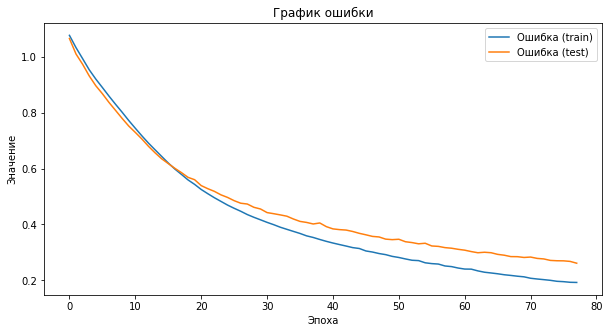

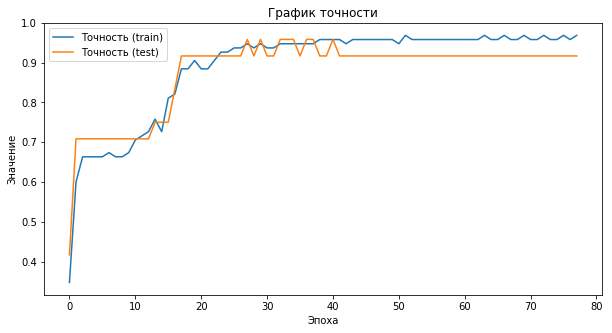

In [28]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

Воспользуемся контрольными точками

In [30]:
from keras.models import load_model

# Загружаем контрольную точку (модель)
# Обратите внимание путь до контрольной точки может отличатся
loaded_model = load_model('./save_points/nn_model_loss-0.42_val_loss-0.46_acc-0.95_val_acc-0.96.hdf5')

# Прдсказываем класс
print(f'Точность предсказания на тренировочных данных {loaded_model.evaluate(X_train, Y_train)[1]}')
print(f'Точность предсказания на тестовых данных {loaded_model.evaluate(X_test, Y_test)[1]}')
predict = loaded_model.predict_classes(X_test)
predict

119/119 [==============================] - 0s 538us/step
Точность предсказания на тренировочных данных 0.9495798339362905
30/30 [==============================] - 0s 33us/step
Точность предсказания на тестовых данных 0.9666666388511658


array([0, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 0, 1, 0, 2, 1, 1, 0, 0, 1,
       2, 0, 0, 0, 0, 1, 0, 0], dtype=int64)

In [31]:
# Преобразуем классы в виде числа в их оригеналы
pipe_y.named_steps['label_encoder'].inverse_transform(predict)

j:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica',
       'Iris-versicolor', 'Iris-virginica', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-virginica', 'Iris-virginica',
       'Iris-virginica', 'Iris-versicolor', 'Iris-virginica',
       'Iris-virginica', 'Iris-setosa', 'Iris-versicolor', 'Iris-setosa',
       'Iris-virginica', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-setosa', 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica',
       'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-versicolor', 'Iris-setosa', 'Iris-setosa'], dtype=object)

In [32]:
# Прдсказываем вероятности для классов
loaded_model.predict(X_train)

array([[8.59547079e-01, 1.26668081e-01, 1.37848901e-02],
       [3.30148474e-03, 2.66179740e-01, 7.30518758e-01],
       [6.53037662e-03, 2.94109762e-01, 6.99359834e-01],
       [8.51217508e-01, 1.34014383e-01, 1.47681003e-02],
       [8.54273960e-02, 5.45228958e-01, 3.69343668e-01],
       [8.04817975e-01, 1.72493845e-01, 2.26882380e-02],
       [8.77807200e-01, 1.11712977e-01, 1.04798581e-02],
       [1.29955202e-01, 5.74446976e-01, 2.95597911e-01],
       [7.91684687e-02, 5.35252929e-01, 3.85578573e-01],
       [9.71121434e-03, 2.91539967e-01, 6.98748827e-01],
       [2.58658989e-03, 2.50878870e-01, 7.46534586e-01],
       [8.70932519e-01, 1.17789216e-01, 1.12782409e-02],
       [8.87720942e-01, 1.03247501e-01, 9.03148018e-03],
       [5.72256465e-03, 2.55342215e-01, 7.38935173e-01],
       [8.00998434e-02, 5.42052150e-01, 3.77847999e-01],
       [8.43487680e-01, 1.39967054e-01, 1.65452380e-02],
       [6.75479323e-03, 2.34260812e-01, 7.58984387e-01],
       [8.11629593e-01, 1.65579

## Бонус - визуализация наших классов
Выполнять это не обязательно

In [33]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf(xx, yy)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


(149, 2)


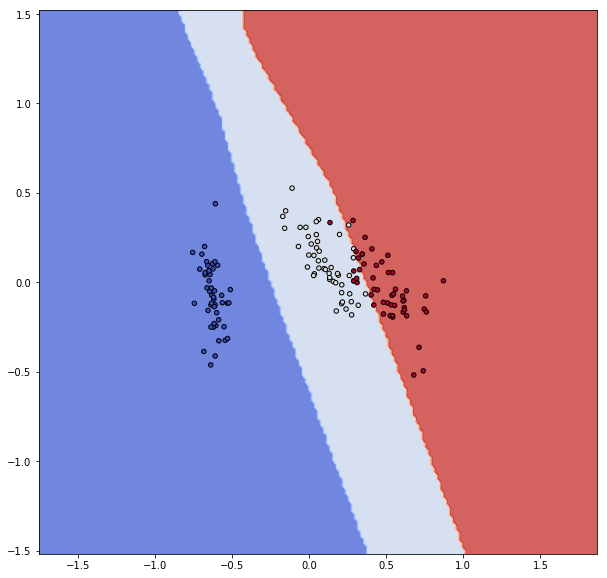

In [34]:
from sklearn.decomposition import PCA
pipe_y_mini = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
])


Y = pipe_y_mini.fit_transform(outletless_data_Y)
X = number_data_ready_X

pca = PCA(n_components=2)

_X = pca.fit_transform(X)
print(_X.shape)

clf_predict = lambda xx, yy: model.predict_classes(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))

X0, X1 = _X[:, 0], _X[:, 1]
xx, yy = make_meshgrid(X0, X1)

clf_predict(xx, yy)

fig, ax = plt.subplots(1,1, figsize=(10, 10))
plot_contours(ax, clf_predict, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')